# Preliminary operations

In [1]:
# General libraries
import pandas as pd
import numpy as np
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import copy
import pickle
import os
import itertools
from math import sqrt

# Tensorflow
import tensorflow as tf

# Scikit-learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression

# Set seeds
seed = 123
tf.keras.utils.set_random_seed(seed)

In [2]:
%run utils.ipynb

# Prepare data

Set name and injection time of the event.

**Time**:
* day (Noon).
* night (4 a.m.). [TODO]
* peak (7 p.m.) [TODO]

**Events**:
* driver_strike(_greedy).
* underground(_greedy).
* long_rides(_greedy).

In [3]:
fail = 'driver_strike'
hour = 'day'

In [4]:
# Read normal data
data_path = 'datasets/raw/sf_normal_final_indicators_93600.csv'
df = pd.read_csv(data_path)
df = df.drop('timestamp', axis = 1)
number_of_features = len(df.columns)

In [5]:
# Aggregate data by 300 timestamps (5 minutes), using average
for column in df.columns:
    df[column] = np.around(df[column].astype(float), 5)
    df[column] = df[column].rolling(window = 300).mean()
df = df[6900:-1800].reset_index(drop = True)

In [6]:
df.columns

Index(['rides_requested', 'rides_canceled', 'rides_not_served',
       'rides_accepted', 'rides_rejections', 'rides_in_progress',
       'idle_drivers', 'responding_drivers', 'pickup_drivers',
       'on_road_drivers', 'moving_drivers', 'active_customers',
       'pending_customers', 'avg_rejections_before_accepted',
       'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price',
       'avg_diff_price', 'avg_actual_expected_price', 'avg_actual_price',
       'avg_actual_expected_price_30min', 'avg_actual_price_30min',
       'avg_actual_expected_price_60min', 'avg_actual_price_60min',
       'avg_current_error_ride_distance', 'avg_speed_max_speed',
       'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min',
       'avg_expected_meeting_time_min', 'avg_expected_total_time_min',
       'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min',
       'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km',
       'avg_distance_per_timestamp

The rides not served index could be scaled by the number of rides requested, in order to weight it based on the requests. Specifically, we apply a logarithmic function which scales the rides not served by the number of rides requested, if they are lower than the average rides requested in a normal scenario.

In [7]:
df['rides_requested'][6900:-1800].mean()

2.3633533245844274

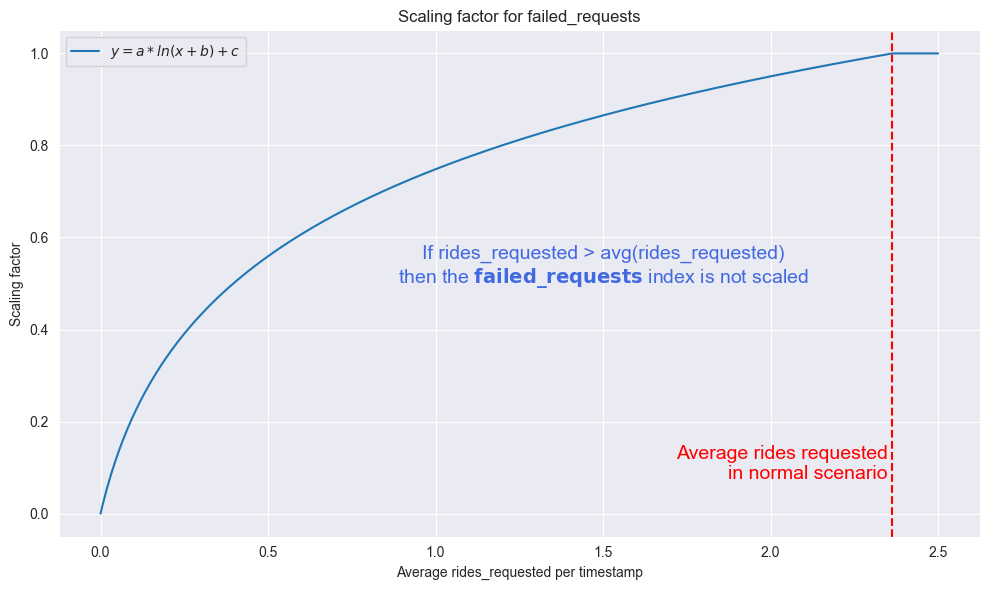

In [8]:
x = np.linspace(0, 2.5, 400)

# Define the values for x1, x2 and their corresponding y values
x1, y1 = 0, 0
x2, y2 = df['rides_requested'][6900:-1800].mean(), 1 
# Adjust b to ensure the function is defined at x = 0
b = 0.1
# Values of ln(x+b) at x1 and x2
ln_x1_b = np.log(x1 + b)
ln_x2_b = np.log(x2 + b)
# System of equations:
# a * ln(0.1) + c = 0
# a * ln(df['rides_requested'].mean()) + c = 1
# We can represent this system as matrix equations A * [a, c] = Y
A = np.array([
    [ln_x1_b, 1],
    [ln_x2_b, 1]
])
Y = np.array([y1, y2])
# Solving for coefficients a and c
coefficients = np.linalg.solve(A, Y)
a, c = coefficients
# Calculate the y values based on the given function
y = np.where(x > df[6900:-1800]['rides_requested'].mean(), 1, (a*np.log(x+b)+c))

# Plotting
plt.figure(figsize = (10, 6))
plt.plot(x, y, label=r'$y=a*ln(x+b)+c$')
plt.title('Scaling factor for failed_requests')
plt.xlabel('Average rides_requested per timestamp')
plt.ylabel('Scaling factor')
plt.axvline(x = df[6900:-1800]['rides_requested'].mean(), color = 'red', linestyle = '--')
plt.annotate('Average rides requested\nin normal scenario', xy = (df['rides_requested'][6900:-1800].mean(), 0), 
             xytext = (2.35, 0.15), horizontalalignment = 'right', verticalalignment = 'top', color = 'red', fontsize = 14)
#plt.text(x = 1.25, y = 0.25, s = "The failed_requests index is scaled \ndepending on the number of rides requested", color = 'royalblue', fontsize = 12, ha = 'center')
plt.text(x = 1.5, y = 0.5, s = "If rides_requested > avg(rides_requested)\nthen the $\mathbf{failed\_requests}$ index is not scaled", color = 'royalblue', fontsize = 14, ha = 'center')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('failed_requests/scaling_factor.png', dpi = 300)
plt.show()

In [9]:
# Read event data
data_path_fail = 'datasets/raw/sf_' + fail + '_final_indicators_18000_' + hour + '.csv'
df_fail = pd.read_csv(data_path_fail)
df_fail = df_fail.drop('timestamp', axis = 1)

In [10]:
# Aggregate data by 300 timestamps (5 minutes), using average
for column in df_fail.columns:
    df_fail[column] = np.around(df_fail[column].astype(float), 5)
    df_fail[column] = df_fail[column].rolling(window = 300).mean()
df_fail = df_fail[6900:-1800].reset_index(drop = True)

In [11]:
df_fail.columns

Index(['rides_requested', 'rides_canceled', 'rides_not_served',
       'rides_accepted', 'rides_rejections', 'rides_in_progress',
       'idle_drivers', 'responding_drivers', 'pickup_drivers',
       'on_road_drivers', 'moving_drivers', 'active_customers',
       'pending_customers', 'avg_rejections_before_accepted',
       'avg_surge_multiplier', 'avg_expected_price', 'avg_real_price',
       'avg_diff_price', 'avg_actual_expected_price', 'avg_actual_price',
       'avg_actual_expected_price_30min', 'avg_actual_price_30min',
       'avg_actual_expected_price_60min', 'avg_actual_price_60min',
       'avg_current_error_ride_distance', 'avg_speed_max_speed',
       'avg_speed_kmh', 'avg_diff_duration_min', 'avg_expected_ride_time_min',
       'avg_expected_meeting_time_min', 'avg_expected_total_time_min',
       'avg_ride_time_min', 'avg_meeting_time_min', 'avg_total_time_min',
       'avg_ride_length_km', 'avg_meeting_length_km', 'avg_total_length_km',
       'avg_distance_per_timestamp

# Dynamic greediness

We compute the dynamic greediness curves, in order to have a clearer view of the events.

In [12]:
df_fail_dynamic = pd.read_csv(data_path_fail)
df_fail_dynamic = df_fail_dynamic.drop('timestamp', axis = 1)
for column in df_fail_dynamic.columns:
    df_fail_dynamic[column] = np.around(df_fail_dynamic[column].astype(float), 5)
    df_fail_dynamic[column] = df_fail_dynamic[column].rolling(window = 300).mean()
df_fail_dynamic['tot_drivers'] = df_fail_dynamic['idle_drivers'] + df_fail_dynamic['moving_drivers']
df_fail_dynamic['ratio_cust_driv'] = df_fail_dynamic['pending_customers']/df_fail_dynamic['tot_drivers']
df_fail_dynamic = df_fail_dynamic[6900:-1800].reset_index(drop = True)

df_fail_roll = pd.read_csv(data_path_fail)
df_fail_roll = df_fail_roll.drop('timestamp', axis = 1)
for column in df_fail_roll.columns:
    df_fail_roll[column] = np.around(df_fail_roll[column].astype(float), 5)
    df_fail_roll[column] = df_fail_roll[column].rolling(window = 1800).mean()
df_fail_roll['tot_drivers'] = df_fail_roll['idle_drivers'] + df_fail_roll['moving_drivers']
df_fail_roll['ratio_cust_driv'] = df_fail_roll['pending_customers']/df_fail_roll['tot_drivers']
df_fail_roll = df_fail_roll[6900:-1800].reset_index(drop = True)

df_fail_dynamic['ratio_cust_driv_surge'] = (df_fail_dynamic['ratio_cust_driv'] - df_fail_roll['ratio_cust_driv']) / (df_fail_dynamic['avg_surge_multiplier'])

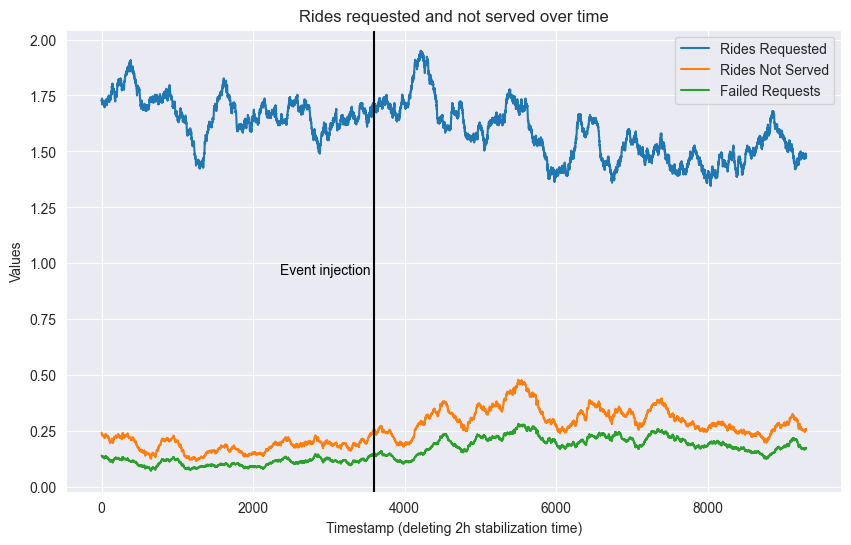

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(df_fail_dynamic['rides_requested'], label = 'Rides Requested')
plt.plot(df_fail_dynamic['rides_not_served'], label = 'Rides Not Served')
plt.plot(df_fail_dynamic['rides_not_served']/df_fail_dynamic['rides_requested'], label = 'Failed Requests')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 1), 
             xytext = (3550, 1), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Rides requested and not served over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

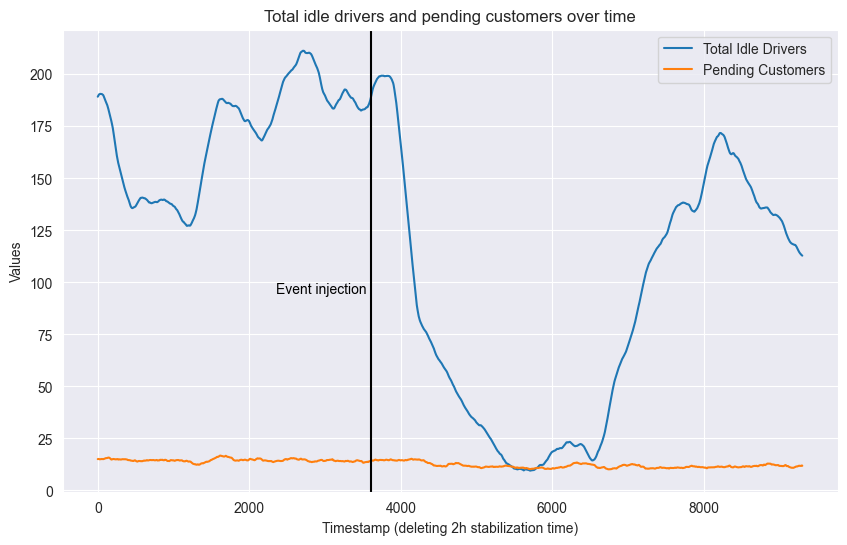

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(df_fail_dynamic['tot_drivers'], label='Total Idle Drivers')
plt.plot(df_fail_dynamic['pending_customers'], label='Pending Customers')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 100), 
             xytext = (3550, 100), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Total idle drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

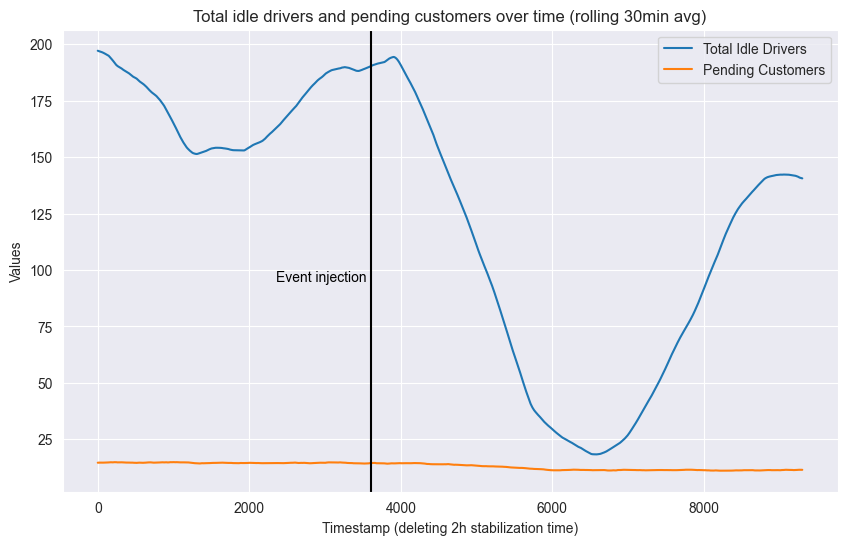

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(df_fail_roll['tot_drivers'], label='Total Idle Drivers')
plt.plot(df_fail_roll['pending_customers'], label='Pending Customers')
plt.axvline(x=3600, color='k')
plt.annotate('Event injection', xy=(3600, 100),
             xytext=(3550, 100), horizontalalignment='right', verticalalignment='top',
             color='k', fontsize=10)
plt.title('Total idle drivers and pending customers over time (rolling 30min avg)')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

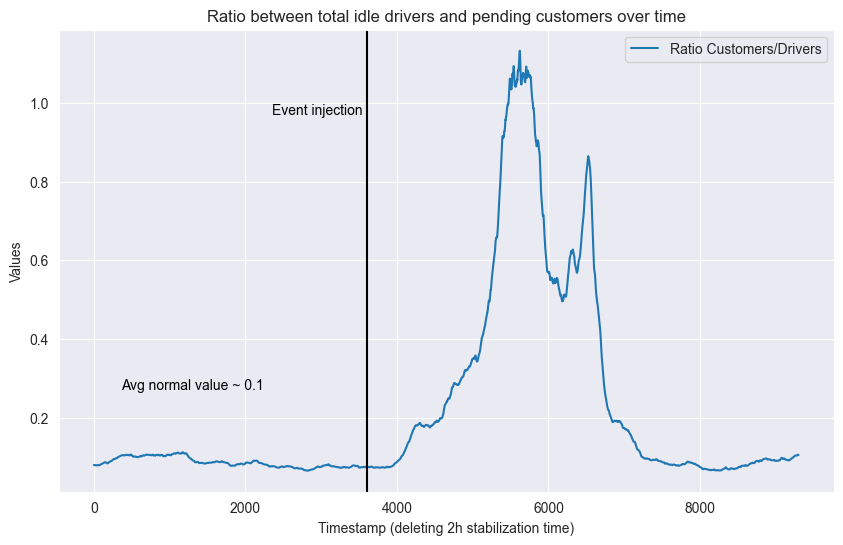

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(df_fail_dynamic['ratio_cust_driv'], label='Ratio Customers/Drivers')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 1), 
             xytext = (3550, 1), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.annotate('Avg normal value ~ 0.1', xy = (1300, 0.3), 
             xytext = (1300, 0.3), horizontalalignment = 'center', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Ratio between total idle drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

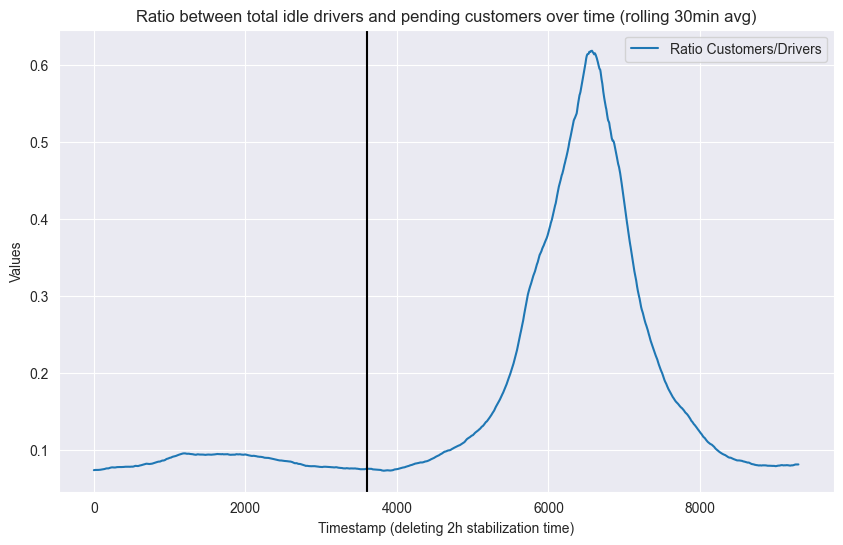

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(df_fail_roll['ratio_cust_driv'], label='Ratio Customers/Drivers')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 0.7),
             xytext = (3550, 0.7), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('Ratio between total idle drivers and pending customers over time (rolling 30min avg)')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

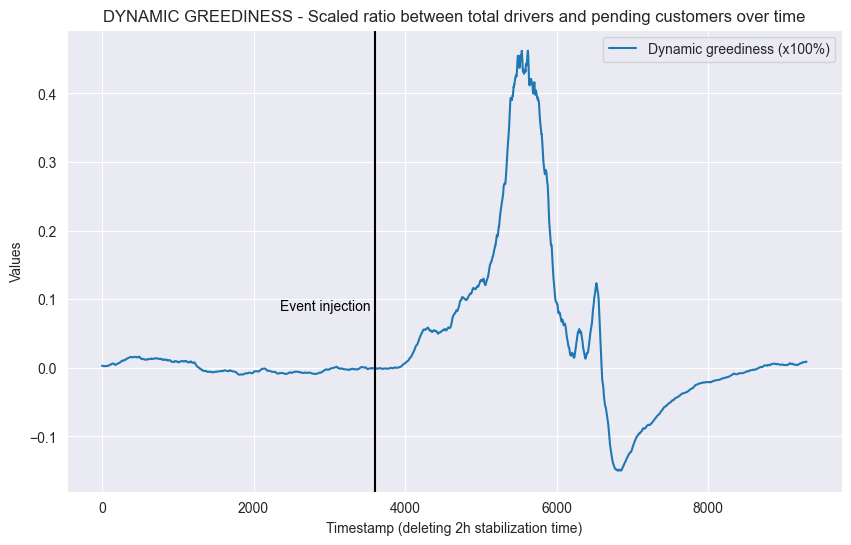

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df_fail_dynamic['ratio_cust_driv_surge'], label='Dynamic greediness (x100%)')
plt.axvline(x = 3600, color = 'k')
plt.annotate('Event injection', xy = (3600, 0.1),
             xytext = (3550, 0.1), horizontalalignment = 'right', verticalalignment = 'top', 
             color = 'k', fontsize = 10)
plt.title('DYNAMIC GREEDINESS - Scaled ratio between total drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

We may also compute dynamic greediness on training data to see its behavior in a normal situation.

In [19]:
df_dynamic = pd.read_csv(data_path)
df_dynamic = df_dynamic.drop('timestamp', axis = 1)
for column in df_dynamic.columns:
    df_dynamic[column] = np.around(df_dynamic[column].astype(float), 5)
    df_dynamic[column] = df_dynamic[column].rolling(window = 600).mean()
df_dynamic = df_dynamic[6900:-1800].reset_index(drop = True)
df_dynamic['tot_drivers'] = df_dynamic['idle_drivers'] + df_dynamic['moving_drivers']
df_dynamic['ratio_cust_driv'] = df_dynamic['pending_customers']/df_dynamic['tot_drivers']

df_roll = pd.read_csv(data_path)
df_roll = df_roll.drop('timestamp', axis = 1)
for column in df_roll.columns:
    df_roll[column] = np.around(df_roll[column].astype(float), 5)
    df_roll[column] = df_roll[column].rolling(window = 1800).mean()
df_roll = df_roll[6900:-1800].reset_index(drop = True)
df_roll['tot_drivers'] = df_roll['idle_drivers'] + df_roll['moving_drivers']
df_roll['ratio_cust_driv'] = df_roll['pending_customers']/df_roll['tot_drivers']

df_dynamic['ratio_cust_driv_surge'] = (df_dynamic['ratio_cust_driv'] - df_roll['ratio_cust_driv']) / (df_dynamic['avg_surge_multiplier'])

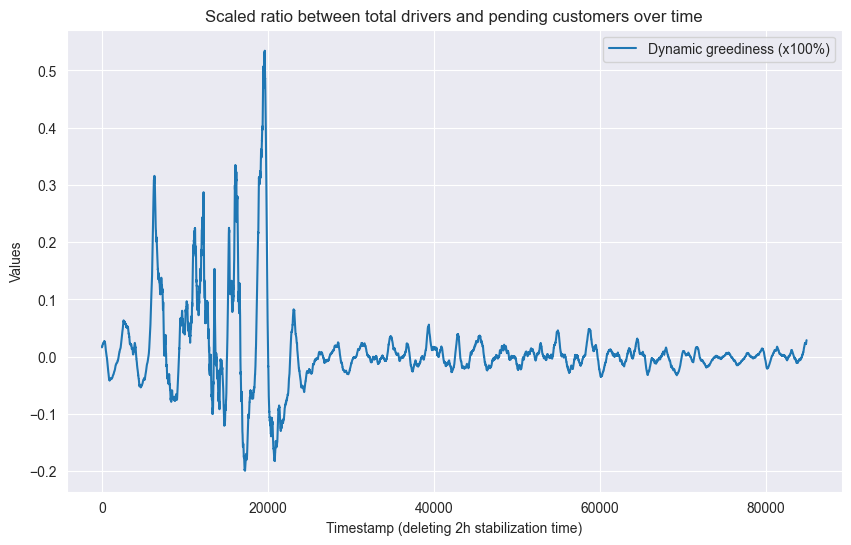

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(df_dynamic['ratio_cust_driv_surge'], label='Dynamic greediness (x100%)')
plt.title('Scaled ratio between total drivers and pending customers over time')
plt.xlabel('Timestamp (deleting 2h stabilization time)')
plt.ylabel('Values')
plt.legend()
plt.show()

# Compute metrics

Now we compute metrics for failure: failed_requests (also weighted by exp), (service_overhead and cost_distortion).

In [21]:
# Computing all the indexes
failed_requests_fail = [0] * len(df_fail)
failed_requests_train = [0] * len(df)
w_failed_requests_fail = [0] * len(df_fail)
w_failed_requests_train = [0] * len(df)
failed_requests_ratio_fail = [0] * len(df_fail)
w_failed_requests_ratio_fail = [0] * len(df_fail)
service_overhead_fail = [0] * len(df_fail)
cost_distortion_fail = [0] * len(df_fail)
cost_distortion_fail_30 = [0] * len(df_fail)
cost_distortion_fail_60 = [0] * len(df_fail)
df_fail['avg_actual_price_60min'] = df_fail['avg_actual_price_60min'].replace(0, 1)
df_fail['avg_actual_expected_price_60min'] = df_fail['avg_actual_expected_price_60min'].replace(0, 1)
factor = df['rides_requested'].mean()

for i in range(0, len(df)):
    failed_train, w_failed_train = compute_failed_requests(df['rides_not_served'][i], df['rides_requested'][i], factor, a, b, c)
    failed_requests_train[i] = failed_train
    w_failed_requests_train[i] = w_failed_train

for i in range(0, len(df_fail)):
    failed, w_failed = compute_failed_requests(df_fail['rides_not_served'][i], df_fail['rides_requested'][i], factor, a, b, c)
    failed_ratio, w_failed_ratio = compute_failed_requests_ratio(df_fail['rides_not_served'][i], df_fail['rides_requested'][i], df_fail['rides_accepted'][i], factor, a, b, c)
    service = compute_service_overhead(df_fail['avg_total_time_min'][i], df_fail['avg_expected_total_time_min'][i])
    cost = compute_cost_distortion(df_fail['avg_real_price'][i], df_fail['avg_actual_price'][i])
    cost_30 = compute_cost_distortion(df_fail['avg_real_price'][i], df_fail['avg_actual_price_30min'][i])
    cost_60 = compute_cost_distortion(df_fail['avg_real_price'][i], df_fail['avg_actual_price_60min'][i])
    failed_requests_fail[i] = failed
    failed_requests_ratio_fail[i] = failed_ratio
    w_failed_requests_ratio_fail[i] = w_failed_ratio
    service_overhead_fail[i] = service
    cost_distortion_fail[i] = cost
    cost_distortion_fail_30[i] = cost_30
    cost_distortion_fail_60[i] = cost_60
    w_failed_requests_fail[i] = w_failed

In [ ]:
# Plot failed_requests index for training data
combined_failed_requests_train = pd.Series(failed_requests_train)
w_combined_failed_requests_train = pd.Series(w_failed_requests_train)
        
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 16})
# plt.plot(combined_failed_requests_train, color = 'b')  
plt.plot(w_combined_failed_requests_train, label = 'Failed requests')  
plt.title('Failed_requests index values - normal scenario')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')

# max_value = combined_failed_requests_train.max()
# plt.axhline(y = max_value, color = 'b', linestyle = '--')
# plt.annotate(f'Max value: {max_value:.2f}', xy = (combined_failed_requests_train.idxmax(), max_value),
#              xytext = (combined_failed_requests_train.idxmax() + 300, max_value + 0.03), 
#              horizontalalignment = 'right', color = 'b')
max_value_w = w_combined_failed_requests_train.max()
plt.axhline(y = max_value_w, color = 'r', linestyle = '--')
plt.annotate(f'Max value: {max_value_w:.2f}', xy = (w_combined_failed_requests_train.idxmax(), max_value_w),
             xytext = (w_combined_failed_requests_train.idxmax() + 15000, max_value_w + 0.03), 
             horizontalalignment = 'right', color = 'r')
plt.legend(loc = 'upper left')
plt.ylim(0, 1)
plt.grid(True)
plt.savefig('failed_requests/normal.png', dpi = 300)
plt.show()

In [23]:
# By calling the function compute_thresholds, the code automatically compute the following thresholds.
perc_95, perc_97, perc_99 = compute_thresholds(combined_failed_requests_train, weight = False)
w_perc_95, w_perc_97, w_perc_99_t = compute_thresholds(w_combined_failed_requests_train, weight = True)

In [24]:
# Computing timestamps exceeding the thresholds
combined_failed_requests = pd.Series(failed_requests_fail)
w_combined_failed_requests = pd.Series(w_failed_requests_fail)
exceed_timestamps = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
w_exceed_timestamps = {
    'perc_95': 0,
    'perc_97': 0,
    'perc_99': 0
}
# Need to define interval sliding window where to look for exceeding timestamps, and % of exceeding timestamps needed to call a failure.
exceed_timestamps = exceed_thresholds(combined_failed_requests, exceed_timestamps, 1800, 0.95, perc_95, perc_97, perc_99)
w_exceed_timestamps = exceed_thresholds(w_combined_failed_requests, w_exceed_timestamps, 1800, 0.95, w_perc_95, w_perc_97, w_perc_99_t)

In [25]:
exceed_timestamps

{'perc_95': 0, 'perc_97': 0, 'perc_99': 0}

In [26]:
w_exceed_timestamps

{'perc_95': 0, 'perc_97': 0, 'perc_99': 0}

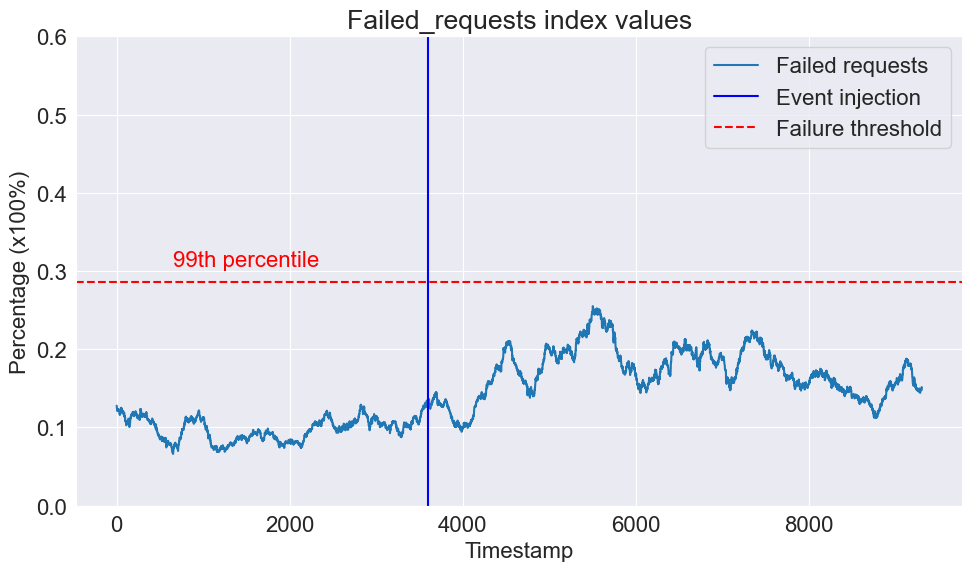

In [27]:
# Plot failed_requests index

plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update({'font.size': 16})

perc_95 = exceed_timestamps.get('perc_95', 0)
perc_97 = exceed_timestamps.get('perc_97', 0)
perc_99 = exceed_timestamps.get('perc_99', 0)
w_perc_95 = w_exceed_timestamps.get('perc_95', 0)
w_perc_97 = w_exceed_timestamps.get('perc_97', 0)
w_perc_99 = w_exceed_timestamps.get('perc_99', 0)
plt.figure(figsize = (10, 6))
#plt.plot(combined_failed_requests, color = 'b')
plt.plot(w_combined_failed_requests, label = 'Failed requests')
plt.title('Failed_requests index values')
plt.xlabel('Timestamp')
plt.ylabel('Percentage (x100%)')
plt.axvline(x = 3600, color = 'blue', label = 'Event injection')
plt.axhline(y = w_perc_99_t, color = 'red', linestyle='--', label = 'Failure threshold')
plt.annotate(f'99th percentile', xy = (1500, w_perc_99_t),
             xytext = (1500, w_perc_99_t + 0.02),
             horizontalalignment = 'center', color = 'r')
# if perc_95 != 0:
#     plt.axvline(x=perc_95, color='b', linestyle='--', label='95th Perc')
# if perc_97 != 0:
#     plt.axvline(x=perc_97, color='b', linestyle='-.', label='97th Perc')
# if perc_99 != 0:
#     plt.axvline(x=perc_99, color='b', linestyle='-', label='99th Perc')
# if w_perc_95 != 0:
#     plt.axvline(x=w_perc_95, color='r', linestyle='--', label='95th Perc (W)')
# if w_perc_97 != 0:
#     plt.axvline(x=w_perc_97, color='r', linestyle='-.', label='97th Perc (W)')
if w_perc_99 != 0:
    plt.axvline(x=w_perc_99, color='r', linestyle='-', label='SES failure')
#max_value = combined_failed_requests.max()
#plt.axhline(y = max_value, color = 'b', linestyle = '--')
#plt.annotate(f'Max value: {max_value:.2f}', xy = (combined_failed_requests.idxmax(), max_value),
#             xytext = (combined_failed_requests.idxmax() + 300, max_value + 0.05),
#             horizontalalignment = 'right', color = 'b')
# max_value_w = w_combined_failed_requests.max()
# plt.axhline(y = max_value_w, color = 'r', linestyle = '--')
# plt.annotate(f'Max value: {max_value_w:.2f}', xy = (w_combined_failed_requests.idxmax(), max_value_w),
#              xytext = (w_combined_failed_requests.idxmax(), max_value_w + 0.05),
#              horizontalalignment = 'center', color = 'r')
plt.ylim(0, 0.6)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('failed_requests/' + fail + '_' + hour + '.png', dpi = 300)
plt.show()